In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=035d90e508bbcba9fc92c067ae0b041d6905b96a85f597de5acf2d406fa145bc
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
from pathlib import Path
from datetime import datetime
import tensorflow
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from pyspark.sql import SparkSession

In [3]:
from google.colab import files
# files.upload()
uploaded = files.upload()

Saving movies.csv to movies.csv


In [4]:
spark = SparkSession.builder.appName("ReadCSV").getOrCreate()

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


In [5]:
data_df = spark.read.csv("/content/movies.csv", inferSchema=True, header=True)
data_df.show()

+--------------------+------+---------+----+--------------------+-----+---------+------------------+--------------------+-----------------+--------------+---------+------------+--------------------+-------+
|                name|rating|    genre|year|            released|score|    votes|          director|              writer|             star|       country|   budget|       gross|             company|runtime|
+--------------------+------+---------+----+--------------------+-----+---------+------------------+--------------------+-----------------+--------------+---------+------------+--------------------+-------+
|         The Shining|     R|    Drama|1980|June 13, 1980 (Un...|  8.4| 927000.0|   Stanley Kubrick|        Stephen King|   Jack Nicholson|United Kingdom|    1.9E7| 4.6998772E7|        Warner Bros.|  146.0|
|     The Blue Lagoon|     R|Adventure|1980|July 2, 1980 (Uni...|  5.8|  65000.0|    Randal Kleiser|Henry De Vere Sta...|   Brooke Shields| United States|4500000.0| 5.88531

In [6]:
# Create our temporary view
data_df.createOrReplaceTempView('movies')

In [7]:
# Top 20 directors based on the number of movies directed
spark.sql("""
  SELECT
    director,
    count(*) AS number_of_movies,
    SUM(votes) AS total_votes
  FROM movies
  GROUP BY director
  ORDER BY 2 DESC
  """).show()

+-----------------+----------------+-----------+
|         director|number_of_movies|total_votes|
+-----------------+----------------+-----------+
|      Woody Allen|              38|  2406300.0|
|   Clint Eastwood|              31|  4593200.0|
|        Directors|              28|  1330100.0|
| Steven Spielberg|              27|   1.1475E7|
|       Ron Howard|              24|  4089000.0|
|Steven Soderbergh|              23|  2889600.0|
|     Ridley Scott|              23|  6459700.0|
|  Joel Schumacher|              22|  2002200.0|
|   Barry Levinson|              20|  1371500.0|
|       Tim Burton|              19|  4861000.0|
|  Martin Scorsese|              19|  7641000.0|
|     Oliver Stone|              18|  1976700.0|
|   Garry Marshall|              18|  1042900.0|
|        Spike Lee|              17|  1197800.0|
|   Brian De Palma|              17|  2143500.0|
|   Stephen Frears|              17|   703700.0|
|     Sidney Lumet|              17|   255285.0|
|      Walter Hill| 

In [8]:
# Which genres tend to have the highest votes?
spark.sql("""SELECT name,
   genre,
   votes,
   country,
   rating,
   director,
   budget,
   gross,
   year
   FROM movies
   WHERE rating IS NOT NULL AND budget IS NOT NULL AND gross IS NOT NULL AND votes IS NOT NULL
   ORDER BY votes DESC""").show(truncate=False)

+-------------------------------------------------+---------+---------+--------------+------+-----------------+---------+-------------+----+
|name                                             |genre    |votes    |country       |rating|director         |budget   |gross        |year|
+-------------------------------------------------+---------+---------+--------------+------+-----------------+---------+-------------+----+
|The Shawshank Redemption                         |Drama    |2400000.0|United States |R     |Frank Darabont   |2.5E7    |2.8817291E7  |1994|
|The Dark Knight                                  |Action   |2400000.0|United States |PG-13 |Christopher Nolan|1.85E8   |1.005973645E9|2008|
|Inception                                        |Action   |2100000.0|United States |PG-13 |Christopher Nolan|1.6E8    |8.36836967E8 |2010|
|Pulp Fiction                                     |Crime    |1900000.0|United States |R     |Quentin Tarantino|8000000.0|2.13928762E8 |1994|
|Forrest Gump

In [9]:
# Summary of ratings
spark.sql("""
  SELECT
    rating,
    count(*) AS number_of_ratings
  FROM movies
  GROUP BY rating
  ORDER BY 2 DESC
  """).show()

+---------+-----------------+
|   rating|number_of_ratings|
+---------+-----------------+
|        R|             3697|
|    PG-13|             2112|
|       PG|             1252|
|Not Rated|              283|
|        G|              153|
|     NULL|               77|
|  Unrated|               52|
|    NC-17|               23|
|    TV-MA|                9|
|    TV-PG|                5|
|        X|                3|
| Approved|                1|
|    TV-14|                1|
+---------+-----------------+



In [10]:
# Runtime vs boxoffice earnings
# How does movie runtime affect ratings and box office earnings?
spark.sql("""
SELECT
    company,
    genre,
    year,
    budget,
    gross,
    votes,
    rating,
    runtime
FROM movies
    WHERE budget IS NOT NULL
    ORDER BY runtime DESC
""").show(truncate=False)

+--------------------------------------+---------+----+---------+-------------+---------+---------+-------+
|company                               |genre    |year|budget   |gross        |votes    |rating   |runtime|
+--------------------------------------+---------+----+---------+-------------+---------+---------+-------+
|TriStar Television                    |Drama    |1993|2.5E7    |1.076996E7   |27000.0  |PG       |271.0  |
|Castle Rock Entertainment             |Drama    |1996|1.8E7    |4770222.0    |37000.0  |PG-13    |242.0  |
|The Ladd Company                      |Crime    |1984|3.0E7    |5473212.0    |321000.0 |R        |229.0  |
|Partisan Productions                  |Adventure|1980|4.4E7    |3484523.0    |14000.0  |R        |219.0  |
|Turner Pictures (I)                   |Biography|2003|5.6E7    |1.2923936E7  |16000.0  |PG-13    |219.0  |
|Dharma Productions                    |Drama    |2001|7500000.0|1.1334547E7  |46000.0  |Not Rated|210.0  |
|Tribeca Productions        

In [11]:
 # Production companies with highest total gross and average highest votes and movie counts
spark.sql("""
SELECT company,SUM(gross) AS GrossSum, AVG(votes) AS AvgVotes,
    count(name) AS MovieCount
FROM movies
GROUP BY company
ORDER BY GrossSum DESC
""").show(truncate=False)


+-----------------------------+---------------+------------------+----------+
|company                      |GrossSum       |AvgVotes          |MovieCount|
+-----------------------------+---------------+------------------+----------+
|Warner Bros.                 |5.6491421806E10|192015.09880239522|334       |
|Universal Pictures           |5.251418889E10 |135496.2679045093 |377       |
|Columbia Pictures            |4.3008941346E10|123845.49397590362|332       |
|Paramount Pictures           |4.0493607415E10|132468.215625     |320       |
|Twentieth Century Fox        |4.0257053857E10|152920.8625       |240       |
|Walt Disney Pictures         |3.6327887792E10|164231.70731707316|123       |
|New Line Cinema              |1.9883797684E10|129262.64367816092|174       |
|Marvel Studios               |1.5065592411E10|773833.3333333334 |12        |
|DreamWorks Animation         |1.1873612858E10|198178.57142857142|28        |
|Touchstone Pictures          |1.1795832638E10|93165.90909090909

In [12]:
# Total movies released in THE YEAR 2000 by month
spark.sql("""
SELECT
    SUBSTRING(released, 1, INSTR(released, ' ') - 1) AS released_month,
    COUNT(*) AS no_of_movies
FROM
    movies
WHERE
    year = 2000
GROUP BY
    released_month
ORDER BY
    no_of_movies DESC;

""").show(truncate=False)



+--------------+------------+
|released_month|no_of_movies|
+--------------+------------+
|October       |23          |
|March         |20          |
|September     |19          |
|February      |18          |
|May           |17          |
|April         |17          |
|January       |16          |
|November      |15          |
|December      |15          |
|August        |14          |
|July          |13          |
|June          |13          |
+--------------+------------+



In [13]:
# Is the movie financially successful?
# If a movie's gross revenue is at least three times greater than its budget, it is considered financially successful
sql_df = spark.sql("""

SELECT
    name,
    rating,
    genre,
    year,
    released,
    score,
    votes,
    director,
    writer,
    star,
    country,
    budget,
    gross,
    company,
    runtime,
    CASE
        WHEN gross/budget > 3 THEN 'Successful'
        ELSE 'Not Successful'
    END AS success_status
FROM movies
    ORDER BY budget DESC;

""")
sql_df.show()


+--------------------+------+---------+----+--------------------+-----+---------+-----------------+-------------------+-----------------+--------------+------+-------------+--------------------+-------+--------------+
|                name|rating|    genre|year|            released|score|    votes|         director|             writer|             star|       country|budget|        gross|             company|runtime|success_status|
+--------------------+------+---------+----+--------------------+-----+---------+-----------------+-------------------+-----------------+--------------+------+-------------+--------------------+-------+--------------+
|   Avengers: Endgame| PG-13|   Action|2019|April 26, 2019 (U...|  8.4| 903000.0|    Anthony Russo| Christopher Markus|Robert Downey Jr.| United States|3.56E8|2.797501328E9|      Marvel Studios|  181.0|    Successful|
|Avengers: Infinit...| PG-13|   Action|2018|April 27, 2018 (U...|  8.4| 897000.0|    Anthony Russo| Christopher Markus|Robert Do

In [15]:
# Convert to CSV
# sql_df.write.csv('movies_out_spark.csv')

In [16]:
movies_df = sql_df.toPandas()
movies_df.head()

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime,success_status
0,Avengers: Endgame,PG-13,Action,2019,"April 26, 2019 (United States)",8.4,903000.0,Anthony Russo,Christopher Markus,Robert Downey Jr.,United States,356000000.0,2.797501e+09,Marvel Studios,181.0,Successful
1,Avengers: Infinity War,PG-13,Action,2018,"April 27, 2018 (United States)",8.4,897000.0,Anthony Russo,Christopher Markus,Robert Downey Jr.,United States,321000000.0,2.048360e+09,Marvel Studios,149.0,Successful
2,Star Wars: Episode VIII - The Last Jedi,PG-13,Action,2017,"December 15, 2017 (United States)",7.0,581000.0,Rian Johnson,Rian Johnson,Daisy Ridley,United States,317000000.0,1.332699e+09,Walt Disney Pictures,152.0,Successful
3,Pirates of the Caribbean: at World's End,PG-13,Action,2007,"May 25, 2007 (United States)",7.1,608000.0,Gore Verbinski,Ted Elliott,Johnny Depp,United States,300000000.0,9.609965e+08,Walt Disney Pictures,169.0,Successful
4,Justice League,PG-13,Action,2017,"November 17, 2017 (United States)",6.1,418000.0,Zack Snyder,Jerry Siegel,Ben Affleck,United States,300000000.0,6.579270e+08,Warner Bros.,120.0,Not Successful


In [17]:
# Trimming the dataframe
trimmed_votes_df = movies_df.drop(movies_df[movies_df.votes <1000].index)
trimmed_df = trimmed_votes_df.dropna()
trimmed_df.head()

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime,success_status
0,Avengers: Endgame,PG-13,Action,2019,"April 26, 2019 (United States)",8.4,903000.0,Anthony Russo,Christopher Markus,Robert Downey Jr.,United States,356000000.0,2.797501e+09,Marvel Studios,181.0,Successful
1,Avengers: Infinity War,PG-13,Action,2018,"April 27, 2018 (United States)",8.4,897000.0,Anthony Russo,Christopher Markus,Robert Downey Jr.,United States,321000000.0,2.048360e+09,Marvel Studios,149.0,Successful
2,Star Wars: Episode VIII - The Last Jedi,PG-13,Action,2017,"December 15, 2017 (United States)",7.0,581000.0,Rian Johnson,Rian Johnson,Daisy Ridley,United States,317000000.0,1.332699e+09,Walt Disney Pictures,152.0,Successful
3,Pirates of the Caribbean: at World's End,PG-13,Action,2007,"May 25, 2007 (United States)",7.1,608000.0,Gore Verbinski,Ted Elliott,Johnny Depp,United States,300000000.0,9.609965e+08,Walt Disney Pictures,169.0,Successful
4,Justice League,PG-13,Action,2017,"November 17, 2017 (United States)",6.1,418000.0,Zack Snyder,Jerry Siegel,Ben Affleck,United States,300000000.0,6.579270e+08,Warner Bros.,120.0,Not Successful


In [18]:
# Sort the dataframe by votes
vote_sorted_df = trimmed_df.sort_values("votes", ignore_index=True)
vote_sorted_df.head()


,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime,success_status
0,There Goes My Baby,R,Comedy,1994,"September 2, 1994 (United States)",6.4,1000.0,Floyd Mutrux,Floyd Mutrux,Dermot Mulroney,United States,10500000.0,123509.0,Nelson Entertainment,99.0,Not Successful
1,Five Days One Summer,PG,Drama,1982,1982 (Japan),6.1,1000.0,Fred Zinnemann,Michael Austin,Sean Connery,United States,15000000.0,199078.0,Cable and Wireless Finance,108.0,Not Successful
2,Twice in a Lifetime,R,Drama,1985,"November 8, 1985 (United States)",6.5,1000.0,Bud Yorkin,Colin Welland,Gene Hackman,United States,8000000.0,8402424.0,Bud Yorkin Productions,111.0,Not Successful
3,Brenda Starr,PG,Adventure,1989,"April 15, 1992 (United States)",4.8,1000.0,Robert Ellis Miller,Noreen Stone,Brooke Shields,United States,16000000.0,67878.0,AM/PM Entertainment,93.0,Not Successful
4,Get Crazy,R,Comedy,1983,"August 5, 1983 (United States)",6.7,1100.0,Allan Arkush,Danny Opatoshu,Malcolm McDowell,United States,5500000.0,1645711.0,D & P Productions,92.0,Not Successful


In [19]:
def extract_month(date_str):
    date_only_str = date_str.split('(')[0].strip()  # Extracting date part
    date_obj = pd.to_datetime(date_only_str, format="%B %d, %Y", errors='coerce')
    return date_obj

# Apply the function to the 'released' column
vote_sorted_df['release_date'] = vote_sorted_df['released'].apply(extract_month)
# Extracting month in words from the 'release_date' column
vote_sorted_df['month'] = vote_sorted_df['release_date'].dt.strftime('%B')
new_df = vote_sorted_df.drop(columns=['release_date', 'released'])
new_df.head()

,name,rating,genre,year,score,votes,director,writer,star,country,budget,gross,company,runtime,success_status,month
0,There Goes My Baby,R,Comedy,1994,6.4,1000.0,Floyd Mutrux,Floyd Mutrux,Dermot Mulroney,United States,10500000.0,123509.0,Nelson Entertainment,99.0,Not Successful,September
1,Five Days One Summer,PG,Drama,1982,6.1,1000.0,Fred Zinnemann,Michael Austin,Sean Connery,United States,15000000.0,199078.0,Cable and Wireless Finance,108.0,Not Successful,NaN
2,Twice in a Lifetime,R,Drama,1985,6.5,1000.0,Bud Yorkin,Colin Welland,Gene Hackman,United States,8000000.0,8402424.0,Bud Yorkin Productions,111.0,Not Successful,November
3,Brenda Starr,PG,Adventure,1989,4.8,1000.0,Robert Ellis Miller,Noreen Stone,Brooke Shields,United States,16000000.0,67878.0,AM/PM Entertainment,93.0,Not Successful,April
4,Get Crazy,R,Comedy,1983,6.7,1100.0,Allan Arkush,Danny Opatoshu,Malcolm McDowell,United States,5500000.0,1645711.0,D & P Productions,92.0,Not Successful,August


In [20]:
# Determining the success/failure of the movie
new_df['gross_by_budget']= new_df['gross']/new_df['budget']
new_df.head()

,name,rating,genre,year,score,votes,director,writer,star,country,budget,gross,company,runtime,success_status,month,gross_by_budget
0,There Goes My Baby,R,Comedy,1994,6.4,1000.0,Floyd Mutrux,Floyd Mutrux,Dermot Mulroney,United States,10500000.0,123509.0,Nelson Entertainment,99.0,Not Successful,September,0.011763
1,Five Days One Summer,PG,Drama,1982,6.1,1000.0,Fred Zinnemann,Michael Austin,Sean Connery,United States,15000000.0,199078.0,Cable and Wireless Finance,108.0,Not Successful,NaN,0.013272
2,Twice in a Lifetime,R,Drama,1985,6.5,1000.0,Bud Yorkin,Colin Welland,Gene Hackman,United States,8000000.0,8402424.0,Bud Yorkin Productions,111.0,Not Successful,November,1.050303
3,Brenda Starr,PG,Adventure,1989,4.8,1000.0,Robert Ellis Miller,Noreen Stone,Brooke Shields,United States,16000000.0,67878.0,AM/PM Entertainment,93.0,Not Successful,April,0.004242
4,Get Crazy,R,Comedy,1983,6.7,1100.0,Allan Arkush,Danny Opatoshu,Malcolm McDowell,United States,5500000.0,1645711.0,D & P Productions,92.0,Not Successful,August,0.299220


In [36]:
# Creating a new column and categorizing it (success or failure) based on the condition specified
new_df['success_failure'] = new_df['gross_by_budget'].map(lambda x: x>3).astype(int)
clean_df = new_df.dropna()
clean_df.head()

,name,rating,genre,year,score,votes,director,writer,star,country,budget,gross,company,runtime,success_status,month,gross_by_budget,success_failure
0,There Goes My Baby,R,Comedy,1994,6.4,1000.0,Floyd Mutrux,Floyd Mutrux,Dermot Mulroney,United States,10500000.0,123509.0,Nelson Entertainment,99.0,Not Successful,September,0.011763,0
2,Twice in a Lifetime,R,Drama,1985,6.5,1000.0,Bud Yorkin,Colin Welland,Gene Hackman,United States,8000000.0,8402424.0,Bud Yorkin Productions,111.0,Not Successful,November,1.050303,0
3,Brenda Starr,PG,Adventure,1989,4.8,1000.0,Robert Ellis Miller,Noreen Stone,Brooke Shields,United States,16000000.0,67878.0,AM/PM Entertainment,93.0,Not Successful,April,0.004242,0
4,Get Crazy,R,Comedy,1983,6.7,1100.0,Allan Arkush,Danny Opatoshu,Malcolm McDowell,United States,5500000.0,1645711.0,D & P Productions,92.0,Not Successful,August,0.299220,0
5,Jekyll and Hyde... Together Again,R,Sci-Fi,1982,6.2,1100.0,Jerry Belson,Monica Mcgowan Johnson,Mark Blankfield,United States,5000000.0,3792188.0,Paramount Pictures,87.0,Not Successful,October,0.758438,0


In [ ]:
# clean_df.dtypes

In [37]:
# Generate our categorical variable lists
clean_df_unique =clean_df.dtypes.index.tolist()
# Determine the number of unique values in each column.
clean_df[clean_df_unique].nunique()

name               5289
rating               10
genre                15
year                 41
score                72
votes               682
director           2041
writer             3177
star               1823
country              50
budget              393
gross              5369
company            1455
runtime             127
success_status        2
month                12
gross_by_budget    5372
success_failure       2
dtype: int64

In [38]:
# clean_df['success_status'].value_counts()

In [39]:
clean_df['rating'].value_counts()

rating
R            2574
PG-13        1724
PG            890
G             109
Not Rated      43
Unrated        16
NC-17          12
TV-MA           2
Approved        1
X               1
Name: count, dtype: int64

In [41]:
# Choose a cutoff value and create a list of rating types to be replaced
valuecount = clean_df['rating'].value_counts()
cutoff_value = 45
clean_df_rating_to_replace = valuecount[valuecount <= cutoff_value].index.tolist()
clean_df_rating_to_replace

# Replace in dataframe
for type in clean_df_rating_to_replace:
    clean_df['rating'] = clean_df['rating'].replace(type,"Other")

# Check to make sure replacement was successful
clean_df['rating'].value_counts()



rating
R        2574
PG-13    1724
PG        890
G         109
Other      75
Name: count, dtype: int64

In [42]:
clean_df['writer'].value_counts()

writer
Woody Allen        32
Stephen King       29
John Hughes        20
Luc Besson         14
Joel Coen          13
                   ..
Joe Klein           1
Robert Clouse       1
Brian Peterson      1
Astrid Lindgren     1
Winston Groom       1
Name: count, Length: 3177, dtype: int64

In [44]:
# Choose a cutoff value and create a list of directors to be replaced
valuecount = clean_df['writer'].value_counts()
cutoff_value = 10
clean_df_star_to_replace = valuecount[valuecount <= cutoff_value].index.tolist()
clean_df_star_to_replace

# Replace in dataframe
for type in clean_df_star_to_replace:
    clean_df['writer'] = clean_df['writer'].replace(type,"Other")

# Check to make sure replacement was successful
clean_df['writer'].value_counts()

writer
Other                 5208
Woody Allen             32
Stephen King            29
John Hughes             20
Luc Besson              14
Joel Coen               13
Wes Craven              12
M. Night Shyamalan      11
Robert Rodriguez        11
David Mamet             11
Quentin Tarantino       11
Name: count, dtype: int64

In [45]:
clean_df['star'].value_counts()

star
Nicolas Cage            40
Tom Hanks               38
Robert De Niro          38
Bruce Willis            34
Denzel Washington       33
                        ..
Jared Harris             1
Helen Slater             1
Wendi McLendon-Covey     1
Anna Paquin              1
Hugo Weaving             1
Name: count, Length: 1823, dtype: int64

In [47]:
# Choose a cutoff value and create a list of star values to be replaced
valuecount = clean_df['star'].value_counts()
cutoff_value = 10
clean_df_star_to_replace = valuecount[valuecount <= cutoff_value].index.tolist()
clean_df_star_to_replace

# Replace in dataframe
for type in clean_df_star_to_replace:
    clean_df['star'] = clean_df['star'].replace(type,"Other")

# Check to make sure replacement was successful
clean_df['star'].value_counts()

star
Other                 3534
Nicolas Cage            40
Robert De Niro          38
Tom Hanks               38
Bruce Willis            34
                      ... 
Michael Caine           11
Jodie Foster            11
Cate Blanchett          11
Kirsten Dunst           11
Scarlett Johansson      11
Name: count, Length: 101, dtype: int64

In [48]:
# Convert categorical variables to dummies
df_encoded = pd.get_dummies(clean_df)

# Display the encoded DataFrame
df_encoded

,year,score,votes,budget,gross,runtime,gross_by_budget,success_failure,name_*batteries not included,name_10 Cloverfield Lane,...,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
0,1994,6.4,1000.0,10500000.0,1.235090e+05,99.0,0.011763,0,False,False,...,False,False,False,False,False,False,False,False,False,True
2,1985,6.5,1000.0,8000000.0,8.402424e+06,111.0,1.050303,0,False,False,...,False,False,False,False,False,False,False,True,False,False
3,1989,4.8,1000.0,16000000.0,6.787800e+04,93.0,0.004242,0,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1983,6.7,1100.0,5500000.0,1.645711e+06,92.0,0.299220,0,False,False,...,False,False,False,False,False,False,False,False,False,False
5,1982,6.2,1100.0,5000000.0,3.792188e+06,87.0,0.758438,0,False,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5379,1994,8.8,1900000.0,55000000.0,6.782261e+08,142.0,12.331384,1,False,False,...,False,False,False,True,False,False,False,False,False,False
5380,1994,8.9,1900000.0,8000000.0,2.139288e+08,154.0,26.741095,1,False,False,...,False,False,False,False,False,False,False,False,True,False
5381,2010,8.8,2100000.0,160000000.0,8.368370e+08,148.0,5.230231,1,False,False,...,False,False,False,True,False,False,False,False,False,False
5382,2008,9.0,2400000.0,185000000.0,1.005974e+09,152.0,5.437695,1,False,False,...,False,False,False,True,False,False,False,False,False,False


In [49]:
# Split our preprocessed data into our features and target arrays
y = df_encoded["success_failure"].values
X = df_encoded.drop(["success_failure"], axis=1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [50]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [51]:
# Number of input features
input_features = len(X_train[0])

nn = Sequential()

# First hidden layer
nn.add(Dense(units=50, input_dim=input_features, activation='relu'))

# Second hidden layer
nn.add(Dense(units=30, activation='relu'))

# Output layer
nn.add(Dense(units=1, activation='sigmoid'))

# Check the structure of the model
nn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                449450    
                                                                 
 dense_1 (Dense)             (None, 30)                1530      
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 451011 (1.72 MB)
Trainable params: 451011 (1.72 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [52]:
# Compile the model

nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [53]:
# Create a callback to save model weights every five epochs
checkpoint_callback = ModelCheckpoint("model_weights_epoch_{epoch:02d}.h5", save_weights_only=True, save_freq=5)


In [54]:
# Train the model

fit_model = nn.fit(X_train_scaled,y_train,epochs=50,callbacks=[checkpoint_callback])

Epoch 1/50
126/126 [==============================] - 4s 18ms/step - loss: 0.5928 - accuracy: 0.6637
Epoch 2/50
126/126 [==============================] - 2s 13ms/step - loss: 0.1164 - accuracy: 0.9655
Epoch 3/50
126/126 [==============================] - 1s 12ms/step - loss: 0.0069 - accuracy: 0.9993
Epoch 4/50
126/126 [==============================] - 2s 14ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 5/50
126/126 [==============================] - 1s 12ms/step - loss: 9.1438e-04 - accuracy: 1.0000
Epoch 6/50
126/126 [==============================] - 1s 11ms/step - loss: 5.9216e-04 - accuracy: 1.0000
Epoch 7/50
126/126 [==============================] - 1s 11ms/step - loss: 4.1887e-04 - accuracy: 1.0000
Epoch 8/50
126/126 [==============================] - 3s 24ms/step - loss: 3.1167e-04 - accuracy: 1.0000
Epoch 9/50
126/126 [==============================] - 2s 17ms/step - loss: 2.4038e-04 - accuracy: 1.0000
Epoch 10/50
126/126 [==============================] - 2s 13ms/step - l

In [55]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

42/42 - 1s - loss: 0.5224 - accuracy: 0.8466 - 636ms/epoch - 15ms/step
Loss: 0.5224339962005615, Accuracy: 0.8466120362281799


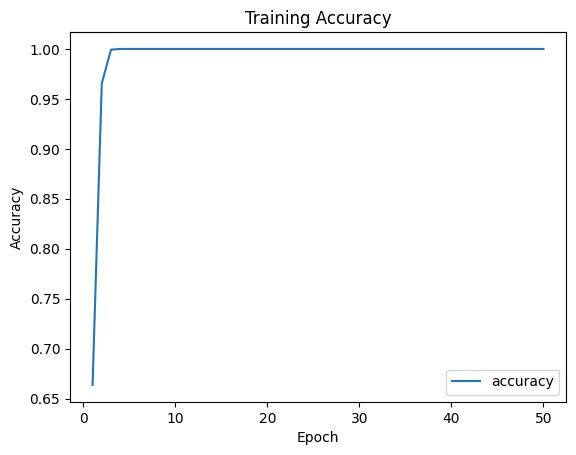

In [56]:
import matplotlib.pyplot as plt
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the accuracy
history_df.plot(y="accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.show()